# Implementation of Vanilla GANs model with EBM
Reference: https://arxiv.org/pdf/1406.2661.pdf

In [1]:
import datetime
import os
import sys
import random
import shutil

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import torch.utils.data as data

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_swiss_roll

In [5]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [6]:
seed = 42

torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
CUDA_NAME = 'cuda:1'
MODEL_NAME = 'VanillaGAN_EBM'
DATASET_PATH = '~/data'

DEVICE = torch.device(CUDA_NAME if torch.cuda.is_available() else 'cpu')    

# General part

## Energy model

In [7]:
class Sampler:

    def __init__(self, model, input_sampler, input_shape, sample_size, max_len=8192):
        """
        Inputs:
            model - Neural network to use for modeling E_theta
            input_sampler - G
            img_shape - Shape of the images to model
            sample_size - Batch size of the samples
            max_len - Maximum number of data points to keep in the buffer
        """
        self.model = model
        self.input_sampler = input_sampler
        self.input_shape = input_shape
        self.sample_size = sample_size
        self.max_len = max_len
        self.examples = [(torch.rand((1,)+input_shape)*2-1) for _ in range(self.sample_size)]

    def sample_new_exmps(self, steps=60, step_size=10):
        """
        Function for getting a new batch of "fake" images.
        Inputs:
            steps - Number of iterations in the MCMC algorithm
            step_size - Learning rate nu in the algorithm above
        """
        # Choose 90% of the batch from the buffer, 10% generate from scratch
        n_new = np.random.binomial(self.sample_size, 0.1)

        is_training = self.input_sampler.training
        self.input_sampler.eval()
        samp_data = self.input_sampler.get_sample(n_new).cpu()
        self.input_sampler.train(is_training)

        old_data = torch.cat(random.choices(self.examples, k=self.sample_size-n_new), dim=0)
        inp_data = torch.cat([samp_data, old_data], dim=0).detach().to(DEVICE)

        # Perform MCMC sampling
        inp_data = Sampler.generate_samples(self.model, inp_data, steps=steps, step_size=step_size)

        # Add new images to the buffer and remove old ones if needed
        self.examples = list(inp_data.to(torch.device('cpu')).chunk(self.sample_size, dim=0)) + self.examples
        self.examples = self.examples[:self.max_len]
        return inp_data

    @staticmethod
    def generate_samples(model, inp_data, steps, step_size, return_data_per_step=False):
        """
        Function for sampling images for a given model.
        Inputs:
            model - Neural network to use for modeling E_theta
            inp_imgs - Images to start from for sampling. If you want to generate new images, enter noise between -1 and 1.
            steps - Number of iterations in the MCMC algorithm.
            step_size - Learning rate nu in the algorithm above
            return_img_per_step - If True, we return the sample at every iteration of the MCMC
        """
        # Before MCMC: set model parameters to "required_grad=False"
        # because we are only interested in the gradients of the input.
        is_training = model.training
        model.eval()
        for p in model.parameters():
            p.requires_grad = False
        inp_data.requires_grad = True

        # Enable gradient calculation if not already the case
        had_gradients_enabled = torch.is_grad_enabled()
        torch.set_grad_enabled(True)

        # We use a buffer tensor in which we generate noise each loop iteration.
        # More efficient than creating a new tensor every iteration.
        noise = torch.randn(inp_data.shape, device=inp_data.device)

        # List for storing generations at each step (for later analysis)
        data_per_step = []

        # Loop over K (steps)
        for _ in range(steps):
            # Part 1: Add noise to the input.
            noise.normal_(0, 0.005)
            inp_data.data.add_(noise.data)
            inp_data.data.clamp_(min=-1.0, max=1.0)

            # Part 2: calculate gradients for the current input.
            out_data = -model(inp_data)
            out_data.sum().backward()
            inp_data.grad.data.clamp_(-0.05, 0.05) # For stabilizing and preventing too high gradients

            # Apply gradients to our current samples
            inp_data.data.add_(-step_size * inp_data.grad.data)
            inp_data.grad.detach_()
            inp_data.grad.zero_()
            inp_data.data.clamp_(min=-1.0, max=1.0)

            if return_data_per_step:
                data_per_step.append(inp_data.clone().detach())

        # Reactivate gradients for parameters for training
        for p in model.parameters():
            p.requires_grad = True
        model.train(is_training)

        # Reset gradient calculation to setting before this function
        torch.set_grad_enabled(had_gradients_enabled)

        if return_data_per_step:
            return torch.stack(data_per_step, dim=0)
        else:
            return inp_data

In [8]:
class EnergyModel(nn.Module):

    def __init__(self, energy_model, input_sampler, input_shape, batch_size):
        super().__init__()

        self.energy_model = energy_model
        self.sampler = Sampler(energy_model, input_sampler, input_shape, batch_size)
        self.example_input_array = torch.zeros(1, *input_shape)

    def forward(self, x):
        z = self.energy_model(x)
        return z

## GAN

In [9]:
class Generator(nn.Module):

    def __init__(self, model: nn.Sequential, input_size, output_shape):
        super().__init__()
        self.model = model
        self.input_size = input_size
        self.output_shape = output_shape
        
    def forward(self, x):
        y_ = self.model(x)
        y_ = y_.view(x.size(0), *self.output_shape)
        return y_

    def get_sample(self, batch_size):
        z = torch.randn(batch_size, self.input_size, device=DEVICE)
        z = self(z).view(batch_size, *self.output_shape)
        return z

In [10]:
class Discriminator(nn.Module):

    def __init__(self, model: nn.Sequential):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.model(y_)
        return y_

## Train

In [11]:
def train(D, D_opt,
          G, G_opt, G_input_size, G_delay_fit_steps,
          EBM, EBM_opt, EBM_alpha, EBM_steps, EBM_step_size, EBM_delay_fit_steps,
          gan_criterion, train_loader, epochs,
          use_ebm=True, log_samples_path=None, log_sampler=None, log_step=500):

    D_labels = torch.ones(batch_size, 1, device=DEVICE)
    D_fakes = torch.zeros(batch_size, 1, device=DEVICE)

    if log_samples_path is not None:
        assert log_sampler is not None
        if os.path.exists(log_samples_path):
            shutil.rmtree(log_samples_path)
        os.makedirs(log_samples_path)

    step = 0
    D.train()
    G.train()

    if use_ebm:
        EBM.train()

    for epoch in range(epochs):
        for (batch, _) in train_loader:
            x = batch.to(DEVICE)
            z = G.get_sample(len(batch))

            # Training Discriminator
            x_ = Sampler.generate_samples(EBM, z.data, EBM_steps, EBM_step_size) if use_ebm else x
            x_outputs = D(x_)
            D_x_loss = gan_criterion(x_outputs, D_labels)

            z_outputs = D(z)
            D_z_loss = gan_criterion(z_outputs, D_fakes)
            D_loss = D_x_loss + D_z_loss

            D.zero_grad()
            D_loss.backward()
            D_opt.step()

            if step % G_delay_fit_steps == 0:
                # Training Generator
                z = G.get_sample(len(batch))
                z_outputs = D(z)
                G_loss = gan_criterion(z_outputs, D_labels)

                G.zero_grad()
                G_loss.backward()
                G_opt.step()

            if use_ebm and step % EBM_delay_fit_steps == 0:
                # Training EBM
                noise_ = torch.randn_like(x) * 0.005
                real_ = (x + noise_).clamp_(min=-1.0, max=1.0)

                fake_ = EBM.sampler.sample_new_exmps(EBM_steps, EBM_step_size)

                # Predict energy score for all images
                inp_ = torch.cat([real_, fake_], dim=0)
                real_out, fake_out = EBM(inp_).chunk(2, dim=0)

                # Calculate losses
                reg_loss = EBM_alpha * (real_out ** 2 + fake_out ** 2).mean()
                cdiv_loss = fake_out.mean() - real_out.mean()
                EBM_loss = reg_loss + cdiv_loss

                EBM.zero_grad()
                EBM_loss.backward()
                EBM_opt.step()

            if step % log_step == 0:
                print(f'Epoch: {epoch+1}/{epochs}, Step: {step},'
                      f'\tD Loss: {np.round(D_loss.item(), 5)},\tG Loss: {np.round(G_loss.item(), 5)},'
                      f'\tEBM Loss: {np.round(EBM_loss.item(), 5) if use_ebm else None}')

            if log_samples_path is not None and step % log_step == 0:
                G.eval()
                img = log_sampler(EBM, G.input_size)
                imsave(f'{log_samples_path}/{MODEL_NAME}_step{str(step).zfill(3)}.jpg', img, cmap='gray')
                G.train()

            step += 1

---

# Moons

In [12]:
batch_size = 128
data_shape = (2,)

G_input_size = 20
G_output_size = np.prod(data_shape)

D_input_size = G_output_size
D_output_size = 1

EBM_input_size = G_output_size

In [13]:
class MLPModel(nn.Module):

    def __init__(self, input_size, out_dim=1):
        super().__init__()

        self.model = nn.Sequential(
                nn.Linear(input_size, 16),
                nn.SiLU(),
                nn.Linear(16, 32),
                nn.SiLU(),
                nn.Linear(32, 64),
                nn.SiLU(),
                nn.Linear(64, 64),
                nn.BatchNorm1d(64),
                nn.SiLU(),
                nn.Linear(64, 64),
                nn.BatchNorm1d(64),
                nn.SiLU(),
                nn.Linear(64, out_dim)
        )

    def forward(self, x):
        x = self.model(x).squeeze(dim=-1)
        return x

In [14]:
x_train = torch.tensor(make_moons(n_samples=15000, shuffle=False, random_state=seed)[0], dtype=torch.float)
x_test = torch.tensor(make_moons(n_samples=2500, shuffle=False)[0], dtype=torch.float)

mean_ = x_train.mean(0)
x_train -= mean_
x_test -= mean_

norm_ = x_train.max(0).values
x_train /= norm_
x_test /= norm_

train_set = list(zip(x_train, torch.empty(x_train.size(0))))
test_set = list(zip(x_test, torch.empty(x_test.size(0))))

train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=4, pin_memory=True, drop_last=True)
test_loader  = data.DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)

In [15]:
G = Generator(
    nn.Sequential(
        nn.Linear(G_input_size, 32),
        nn.LeakyReLU(0.2),
        nn.Linear(32, 64),
        nn.BatchNorm1d(64),
        nn.LeakyReLU(0.2),
        nn.Linear(64, G_output_size),
        nn.Tanh()
    ),
    G_input_size, data_shape
).to(DEVICE)

D = Discriminator(
    nn.Sequential(
        nn.Linear(D_input_size, 32),
        nn.LeakyReLU(0.2),
        nn.Linear(32, 32),
        nn.BatchNorm1d(32),
        nn.LeakyReLU(0.2),
        nn.Linear(32, 16),
        nn.LeakyReLU(0.2),
        nn.Linear(16, 8),
        nn.LeakyReLU(0.2),
        nn.Linear(8, D_output_size),
        nn.Sigmoid()
    )
).to(DEVICE)

In [16]:
D_opt = torch.optim.Adam(D.parameters(), lr=0.002, betas=(0.5, 0.999))

G_opt = torch.optim.Adam(G.parameters(), lr=0.002, betas=(0.5, 0.999))
G_delay_fit_steps = 1

gan_criterion = nn.BCELoss()
epochs = 100

In [17]:
train(D, D_opt,
      G, G_opt, G_input_size, G_delay_fit_steps,
      None, None, None, None, None, None,
      gan_criterion, train_loader, epochs, use_ebm=False, log_step=1000
)

Epoch: 1/100, Step: 0,	D Loss: 1.39828,	G Loss: 0.58401,	EBM Loss: None
Epoch: 9/100, Step: 1000,	D Loss: 0.76943,	G Loss: 1.65597,	EBM Loss: None
Epoch: 18/100, Step: 2000,	D Loss: 0.51585,	G Loss: 2.2689,	EBM Loss: None
Epoch: 26/100, Step: 3000,	D Loss: 0.67554,	G Loss: 3.05547,	EBM Loss: None
Epoch: 35/100, Step: 4000,	D Loss: 0.50842,	G Loss: 4.32464,	EBM Loss: None
Epoch: 43/100, Step: 5000,	D Loss: 0.89506,	G Loss: 2.71559,	EBM Loss: None
Epoch: 52/100, Step: 6000,	D Loss: 0.54763,	G Loss: 3.23861,	EBM Loss: None
Epoch: 60/100, Step: 7000,	D Loss: 0.93169,	G Loss: 2.22728,	EBM Loss: None
Epoch: 69/100, Step: 8000,	D Loss: 0.53379,	G Loss: 2.5265,	EBM Loss: None
Epoch: 77/100, Step: 9000,	D Loss: 0.5887,	G Loss: 3.82885,	EBM Loss: None
Epoch: 86/100, Step: 10000,	D Loss: 0.69593,	G Loss: 3.96999,	EBM Loss: None
Epoch: 95/100, Step: 11000,	D Loss: 0.43521,	G Loss: 4.65017,	EBM Loss: None


In [18]:
G.eval()
D.eval()

pass

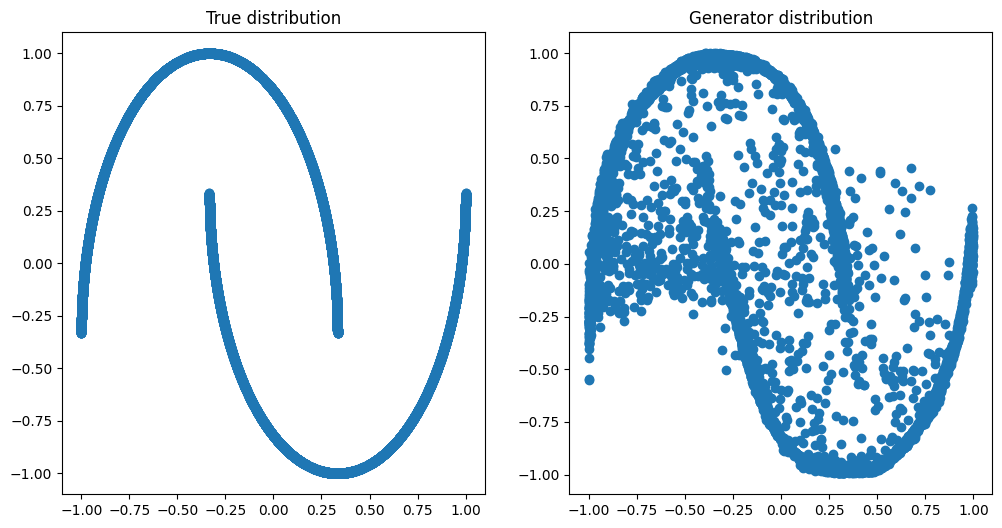

In [19]:
_, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].scatter(x_train[:, 0], x_train[:, 1])
axes[0].set_title('True distribution')

z = G.get_sample(10000).cpu().data

axes[1].scatter(z[:, 0], z[:, 1])
axes[1].set_title('Generator distribution')

plt.show()

In [36]:
G = Generator(
    nn.Sequential(
        nn.Linear(G_input_size, 32),
        nn.LeakyReLU(0.2),
        nn.Linear(32, 64),
        nn.BatchNorm1d(64),
        nn.LeakyReLU(0.2),
        nn.Linear(64, G_output_size),
        nn.Tanh()
    ),
    G_input_size, data_shape
).to(DEVICE)

D = Discriminator(
    nn.Sequential(
        nn.Linear(D_input_size, 32),
        nn.LeakyReLU(0.2),
        nn.Linear(32, 32),
        nn.BatchNorm1d(32),
        nn.LeakyReLU(0.2),
        nn.Linear(32, 16),
        nn.LeakyReLU(0.2),
        nn.Linear(16, 8),
        nn.LeakyReLU(0.2),
        nn.Linear(8, D_output_size),
        nn.Sigmoid()
    )
).to(DEVICE)

EBM = EnergyModel(MLPModel(EBM_input_size), G, data_shape, batch_size).to(DEVICE)

In [37]:
D_opt = torch.optim.Adam(D.parameters(), lr=0.002, betas=(0.5, 0.999))

G_opt = torch.optim.Adam(G.parameters(), lr=0.002, betas=(0.5, 0.999))
G_delay_fit_steps = 1

EBM_opt = torch.optim.Adam(EBM.parameters(), lr=0.0001)
EBM_alpha = 0.1
EBM_steps = 30
EBM_step_size = 10
EBM_delay_fit_steps = 1

gan_criterion = nn.BCELoss()
epochs = 100

In [38]:
train(D, D_opt,
      G, G_opt, G_input_size, G_delay_fit_steps,
      EBM, EBM_opt, EBM_alpha, EBM_steps, EBM_step_size, EBM_delay_fit_steps,
      gan_criterion, train_loader, epochs, log_step=1000
)

Epoch: 1/100, Step: 0,	D Loss: 1.40857,	G Loss: 0.56924,	EBM Loss: 0.15677
Epoch: 9/100, Step: 1000,	D Loss: 1.3863,	G Loss: 0.68848,	EBM Loss: -2.77453
Epoch: 18/100, Step: 2000,	D Loss: 1.3863,	G Loss: 0.68594,	EBM Loss: -3.20012
Epoch: 26/100, Step: 3000,	D Loss: 1.38629,	G Loss: 0.69103,	EBM Loss: -3.46739
Epoch: 35/100, Step: 4000,	D Loss: 1.38629,	G Loss: 0.69014,	EBM Loss: -4.11775
Epoch: 43/100, Step: 5000,	D Loss: 1.38629,	G Loss: 0.68847,	EBM Loss: -3.84292
Epoch: 52/100, Step: 6000,	D Loss: 1.3863,	G Loss: 0.69179,	EBM Loss: -3.67798
Epoch: 60/100, Step: 7000,	D Loss: 1.38629,	G Loss: 0.69104,	EBM Loss: -3.60544
Epoch: 69/100, Step: 8000,	D Loss: 1.3863,	G Loss: 0.69339,	EBM Loss: -4.07734
Epoch: 77/100, Step: 9000,	D Loss: 1.38629,	G Loss: 0.69239,	EBM Loss: -4.49533
Epoch: 86/100, Step: 10000,	D Loss: 1.38629,	G Loss: 0.69249,	EBM Loss: -4.33154
Epoch: 95/100, Step: 11000,	D Loss: 1.3863,	G Loss: 0.69186,	EBM Loss: -4.38282


In [39]:
G.eval()
D.eval()
EBM.eval()

pass

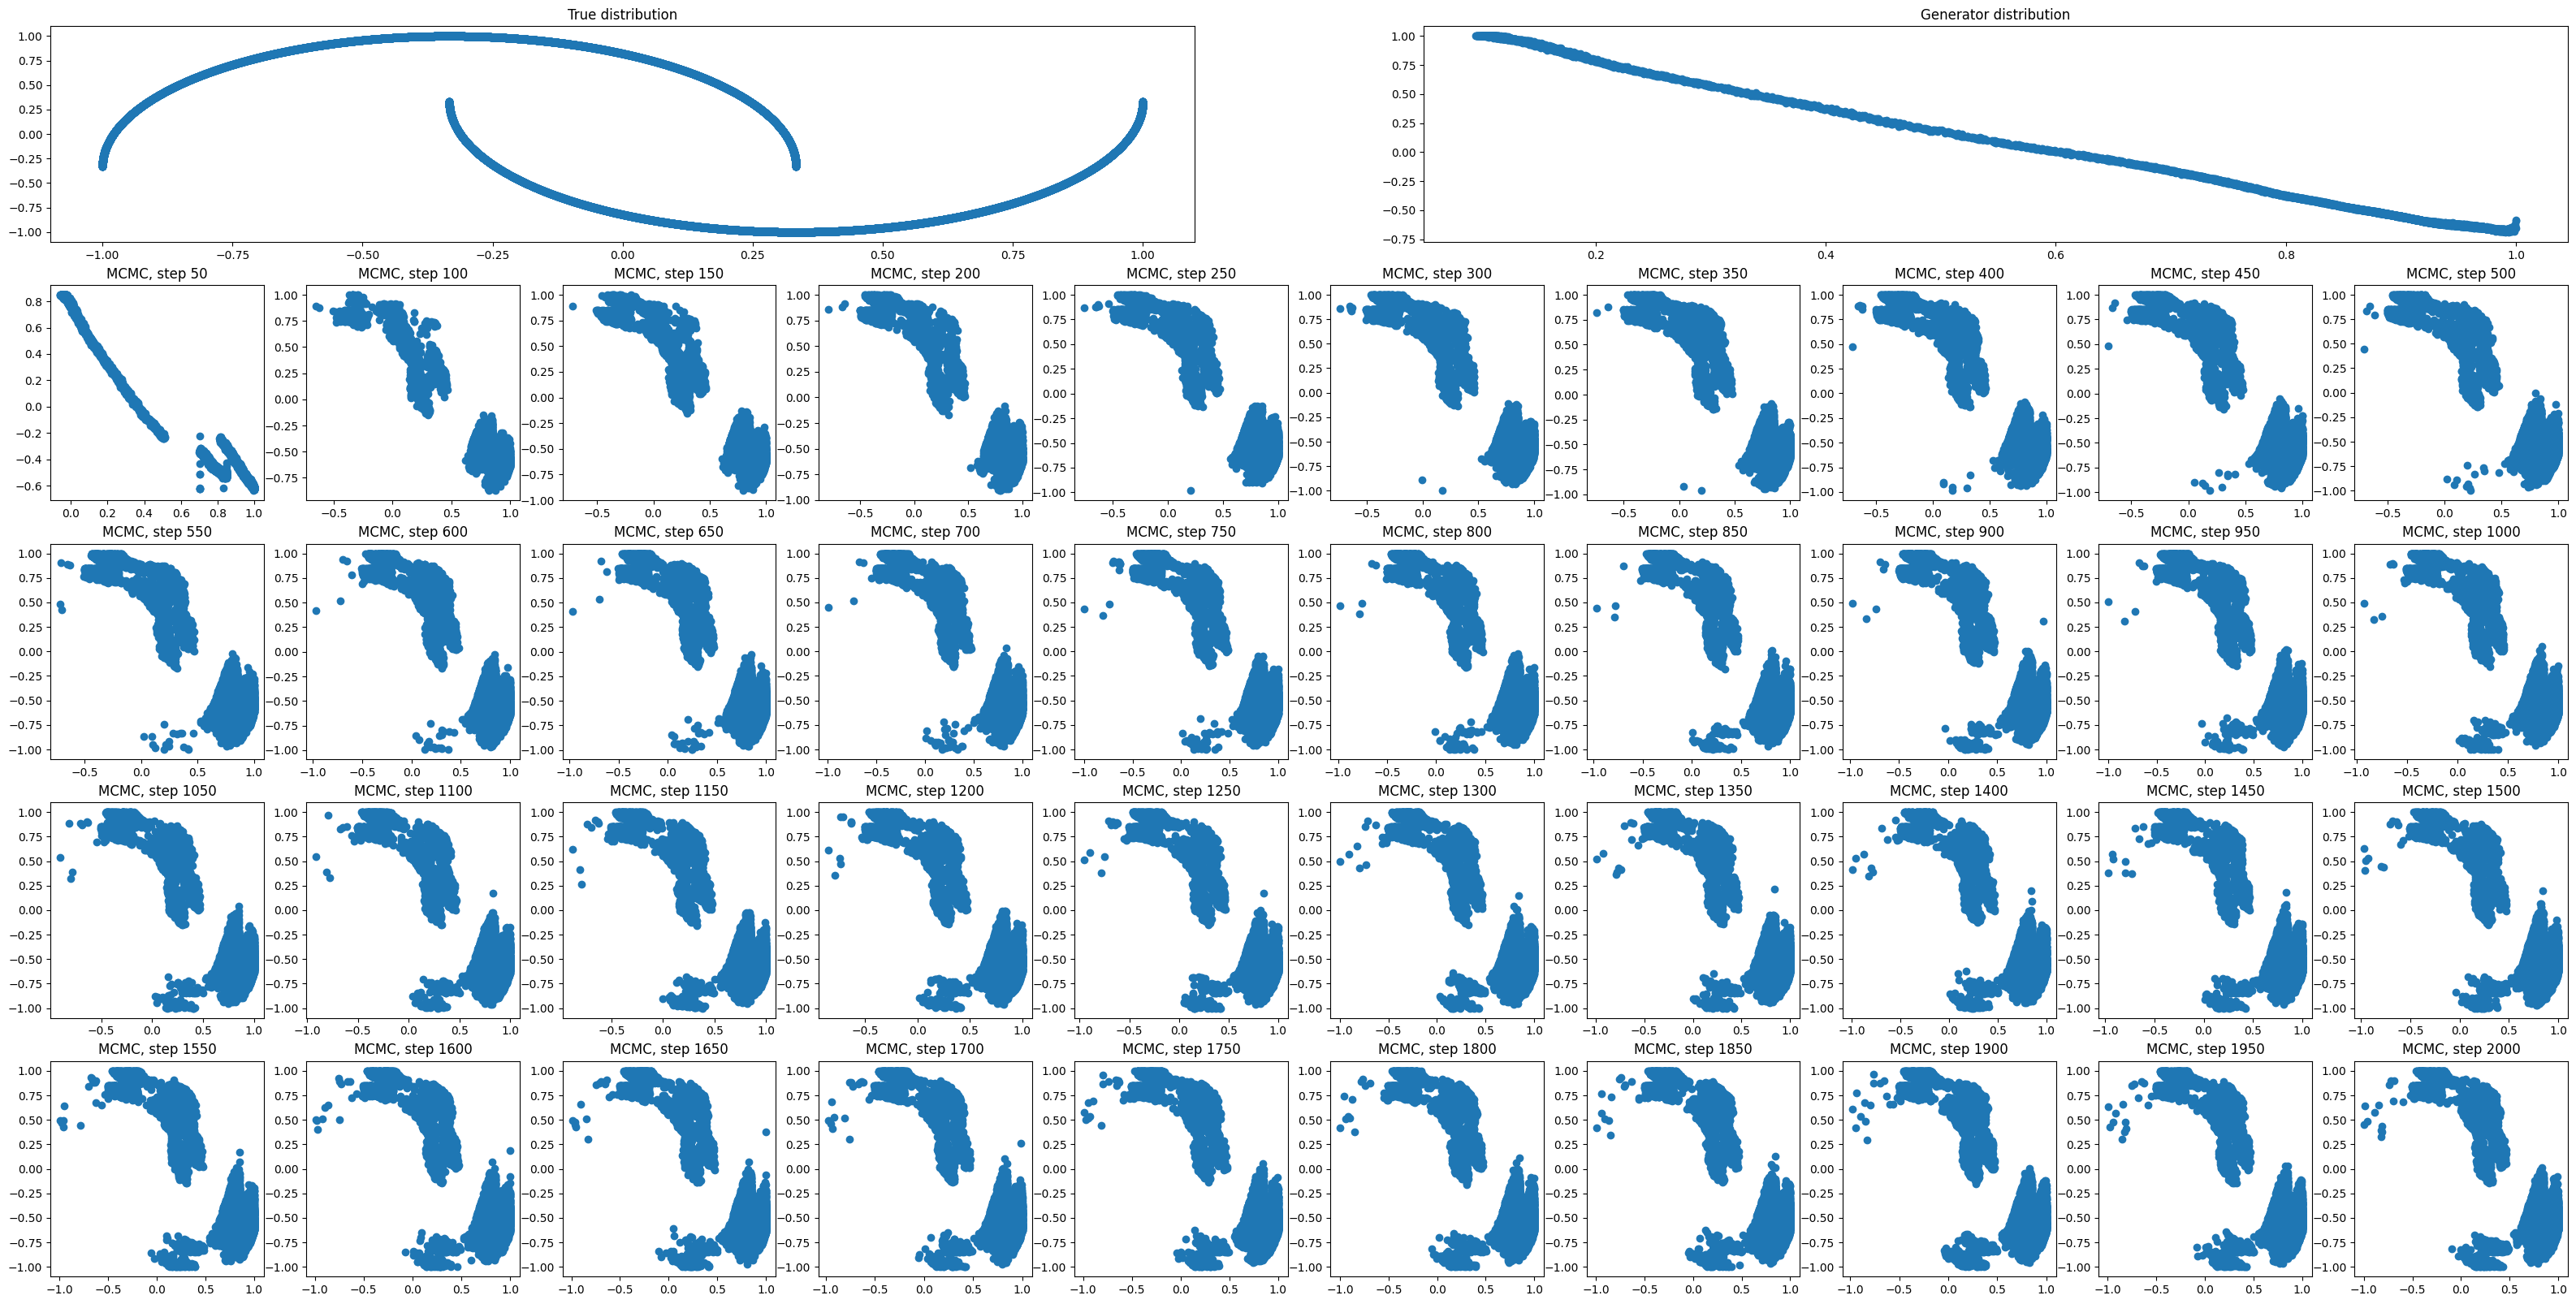

In [45]:
T = 2000
t = 50
n = 10

z = G.get_sample(10000).cpu().data
xs = Sampler.generate_samples(EBM, z.to(DEVICE), T, 3, return_data_per_step=True)

fig = plt.figure(figsize=(4*n, 4*(1+T//(n*t))))

ax = plt.subplot(1+T//(n*t), 2, 1)
ax.scatter(x_train[:, 0], x_train[:, 1])
ax.set_title('True distribution')

ax = plt.subplot(1+T//(n*t), 2, 2)
ax.scatter(z[:, 0], z[:, 1])
ax.set_title('Generator distribution')

for i, x in enumerate(xs[::t]):
    ax = plt.subplot(1+T//(n*t), n, n+1+i)
    x = x.cpu().detach().numpy()
    ax.scatter(x[:, 0], x[:, 1])
    ax.set_title(f'MCMC, step {t*(i+1)}')

# Swiss roll

In [26]:
batch_size = 128
data_shape = (2,)

G_input_size = 20
G_output_size = np.prod(data_shape)

D_input_size = G_output_size
D_output_size = 1

EBM_input_size = G_output_size

In [27]:
x_train = torch.tensor(make_swiss_roll(n_samples=15000, random_state=seed)[0][:, [0, 2]], dtype=torch.float)
x_test = torch.tensor(make_swiss_roll(n_samples=2500)[0][:, [0, 2]], dtype=torch.float)

mean_ = x_train.mean(0)
x_train -= mean_
x_test -= mean_

norm_ = x_train.max(0).values
x_train /= norm_
x_test /= norm_

train_set = list(zip(x_train, torch.empty(x_train.size(0))))
test_set = list(zip(x_test, torch.empty(x_test.size(0))))

train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=4, pin_memory=True, drop_last=True)
test_loader  = data.DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)

In [28]:
G = Generator(
    nn.Sequential(
        nn.Linear(G_input_size, 32),
        nn.LeakyReLU(0.2),
        nn.Linear(32, 64),
        nn.BatchNorm1d(64),
        nn.LeakyReLU(0.2),
        nn.Linear(64, G_output_size),
        nn.Tanh()
    ),
    G_input_size, data_shape
).to(DEVICE)

D = Discriminator(
    nn.Sequential(
        nn.Linear(D_input_size, 32),
        nn.LeakyReLU(0.2),
        nn.Linear(32, 32),
        nn.BatchNorm1d(32),
        nn.LeakyReLU(0.2),
        nn.Linear(32, 16),
        nn.LeakyReLU(0.2),
        nn.Linear(16, 8),
        nn.LeakyReLU(0.2),
        nn.Linear(8, D_output_size),
        nn.Sigmoid()
    )
).to(DEVICE)

EBM = EnergyModel(MLPModel(EBM_input_size), G, data_shape, batch_size).to(DEVICE)

In [29]:
D_opt = torch.optim.Adam(D.parameters(), lr=0.002, betas=(0.5, 0.999))

G_opt = torch.optim.Adam(G.parameters(), lr=0.002, betas=(0.5, 0.999))
G_delay_fit_steps = 1

EBM_opt = torch.optim.Adam(EBM.parameters(), lr=0.0001)
EBM_alpha = 0.1
EBM_steps = 30
EBM_step_size = 5
EBM_delay_fit_steps = 1

gan_criterion = nn.BCELoss()
epochs = 100

In [30]:
train(D, D_opt,
      G, G_opt, G_input_size, G_delay_fit_steps,
      EBM, EBM_opt, EBM_alpha, EBM_steps, EBM_step_size, EBM_delay_fit_steps,
      gan_criterion, train_loader, epochs, log_step=1000
)

Epoch: 1/100, Step: 0,	D Loss: 1.38699,	G Loss: 0.69177,	EBM Loss: 0.28965
Epoch: 9/100, Step: 1000,	D Loss: 1.38629,	G Loss: 0.69222,	EBM Loss: -0.32387
Epoch: 18/100, Step: 2000,	D Loss: 1.38629,	G Loss: 0.69255,	EBM Loss: -0.57484
Epoch: 26/100, Step: 3000,	D Loss: 1.38629,	G Loss: 0.69229,	EBM Loss: -1.90793
Epoch: 35/100, Step: 4000,	D Loss: 1.38629,	G Loss: 0.69297,	EBM Loss: -3.01405
Epoch: 43/100, Step: 5000,	D Loss: 1.38629,	G Loss: 0.69249,	EBM Loss: -3.25539
Epoch: 52/100, Step: 6000,	D Loss: 1.38629,	G Loss: 0.69245,	EBM Loss: -3.64154
Epoch: 60/100, Step: 7000,	D Loss: 1.38629,	G Loss: 0.69285,	EBM Loss: -3.77033
Epoch: 69/100, Step: 8000,	D Loss: 1.38629,	G Loss: 0.69305,	EBM Loss: -3.8763
Epoch: 77/100, Step: 9000,	D Loss: 1.38629,	G Loss: 0.6929,	EBM Loss: -3.87492
Epoch: 86/100, Step: 10000,	D Loss: 1.38629,	G Loss: 0.69272,	EBM Loss: -3.49899
Epoch: 95/100, Step: 11000,	D Loss: 1.38629,	G Loss: 0.69292,	EBM Loss: -3.84702


In [31]:
G.eval()
D.eval()
EBM.eval()

pass

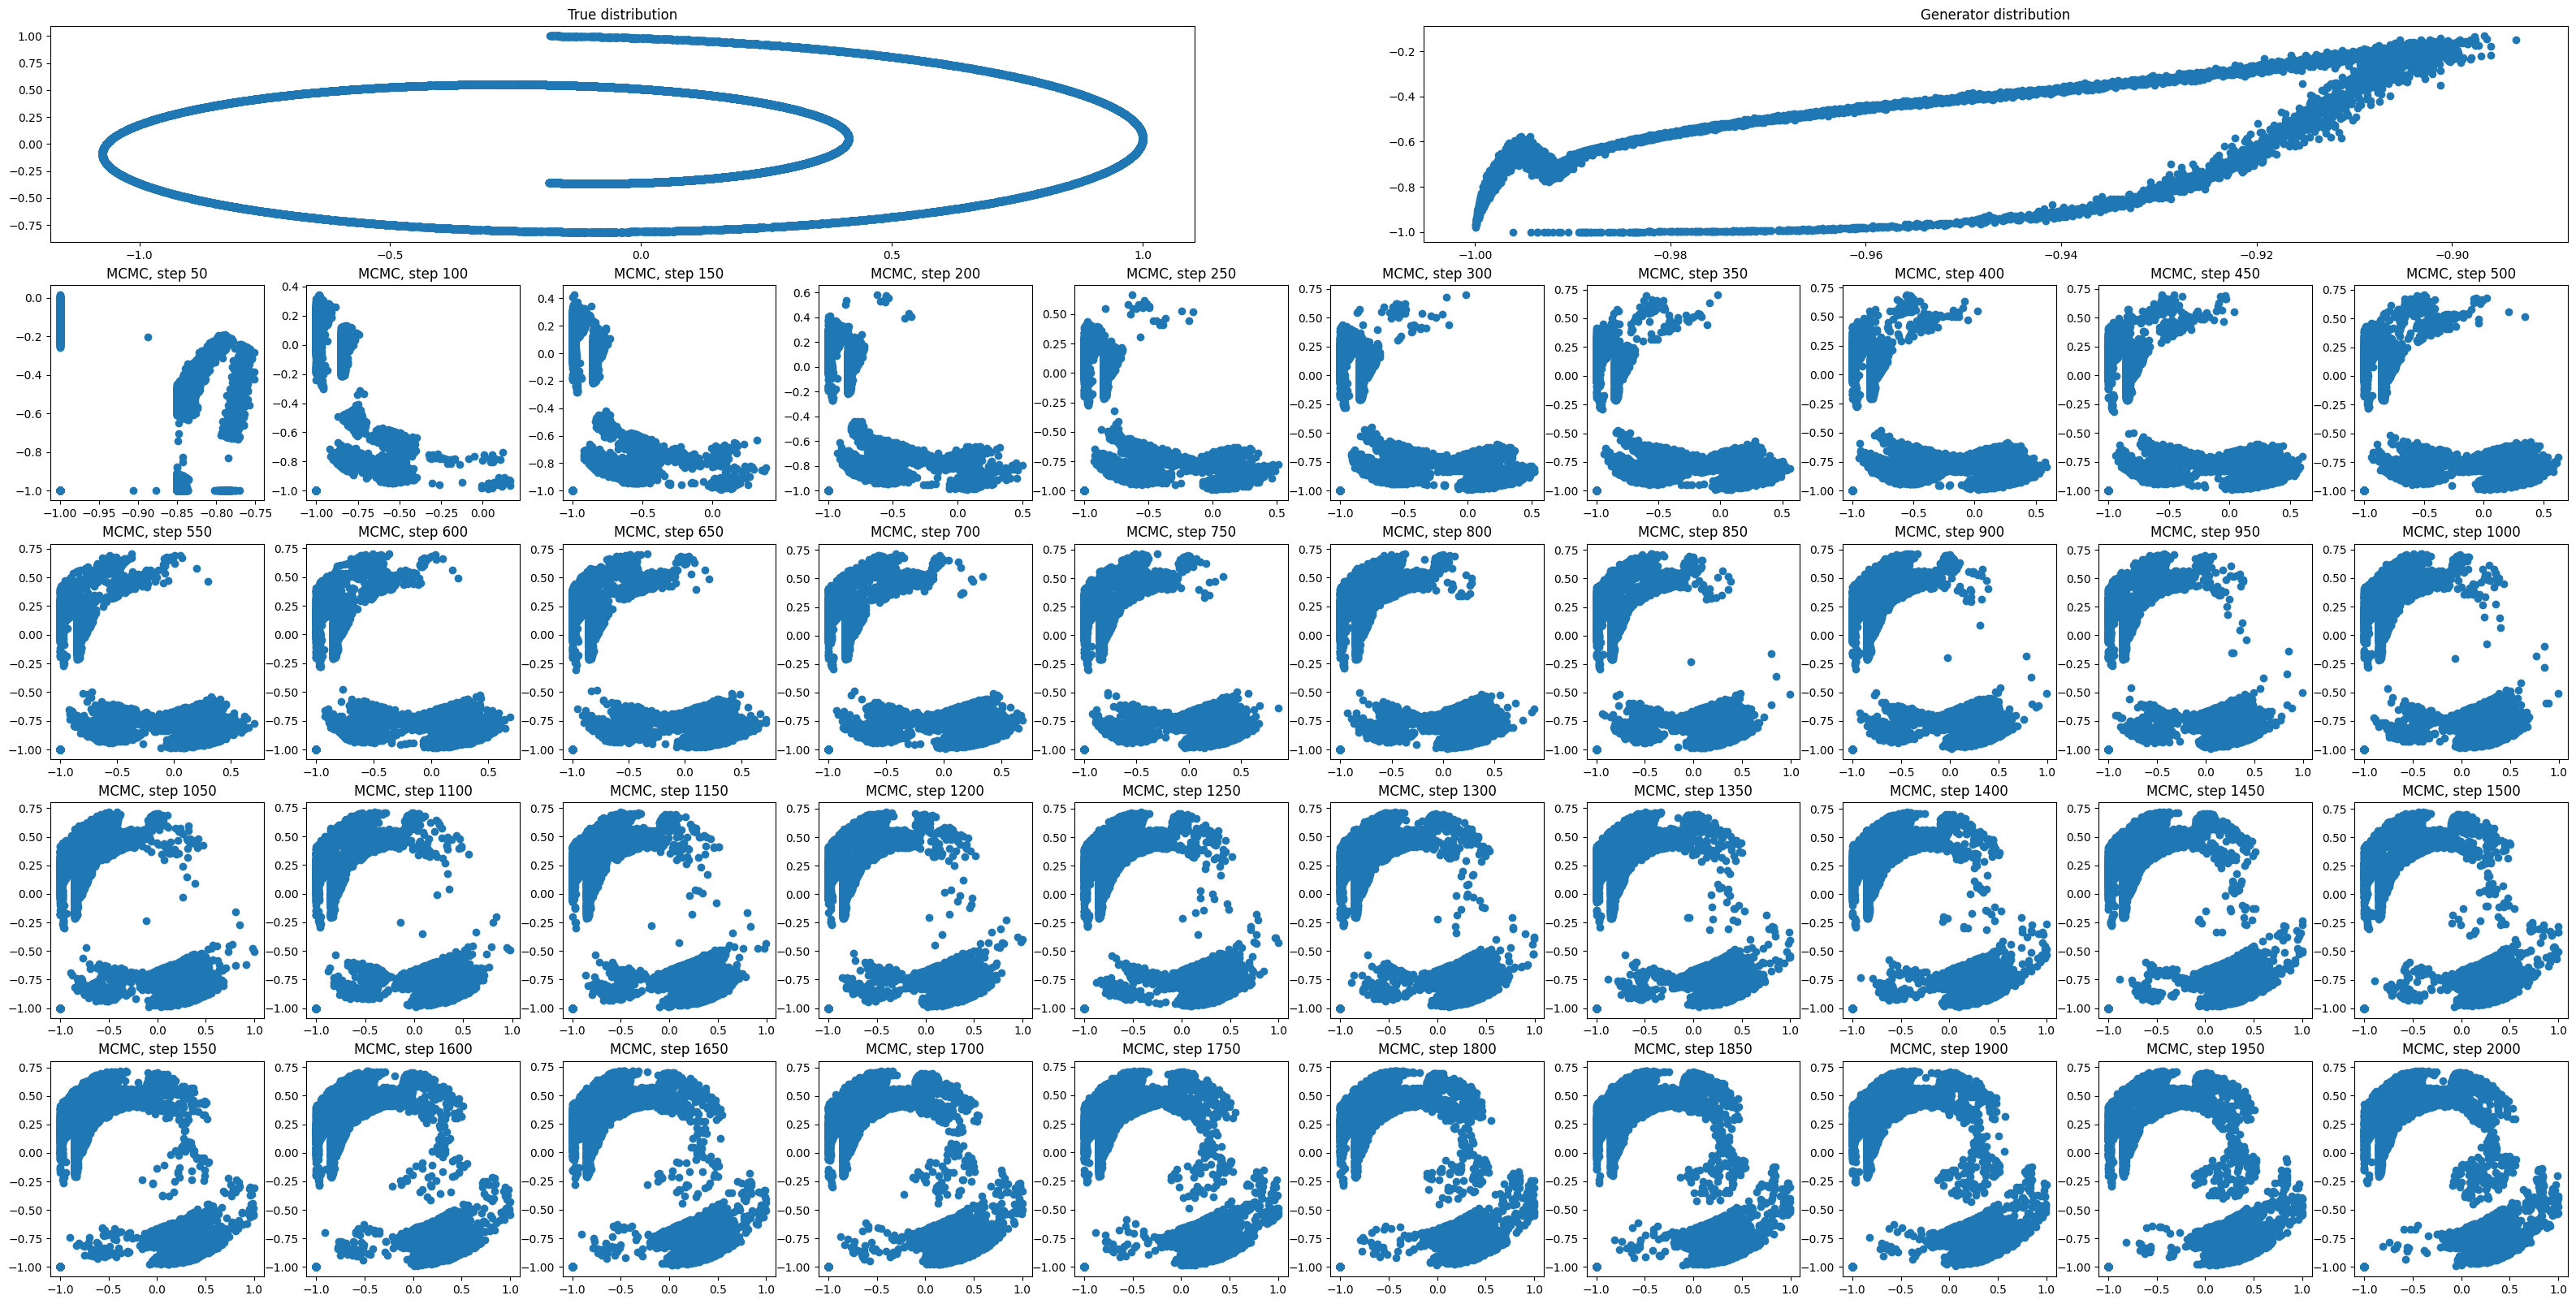

In [32]:
T = 2000
t = 50
n = 10

z = G.get_sample(10000).cpu().data
xs = Sampler.generate_samples(EBM, z.to(DEVICE), T, 3, return_data_per_step=True)

fig = plt.figure(figsize=(4*n, 4*(1+T//(n*t))))

ax = plt.subplot(1+T//(n*t), 2, 1)
ax.scatter(x_train[:, 0], x_train[:, 1])
ax.set_title('True distribution')

ax = plt.subplot(1+T//(n*t), 2, 2)
ax.scatter(z[:, 0], z[:, 1])
ax.set_title('Generator distribution')

for i, x in enumerate(xs[::t]):
    ax = plt.subplot(1+T//(n*t), n, n+1+i)
    x = x.cpu().detach().numpy()
    ax.scatter(x[:, 0], x[:, 1])
    ax.set_title(f'MCMC, step {t*(i+1)}')

# MNIST

In [46]:
batch_size = 128
img_shape = (1, 28, 28)

G_input_size = 100
G_output_size = np.prod(img_shape)

D_input_size = G_output_size
D_output_size = 1

EBM_input_size = G_output_size

In [76]:
class CNNModel(nn.Module):

    def __init__(self, hidden_features=32, out_dim=1, **kwargs):
        super().__init__()
        # We increase the hidden dimension over layers. Here pre-calculated for simplicity.
        c_hid1 = hidden_features//2
        c_hid2 = hidden_features
        c_hid3 = hidden_features*2

        # Series of convolutions and Swish activation functions
        self.cnn_layers = nn.Sequential(
                nn.Conv2d(1, c_hid1, kernel_size=5, stride=2, padding=4), # [16x16] - Larger padding to get 32x32 image
                nn.SiLU(),
                nn.Conv2d(c_hid1, c_hid2, kernel_size=3, stride=2, padding=1), #  [8x8]
                nn.SiLU(),
                nn.Conv2d(c_hid2, c_hid3, kernel_size=3, stride=2, padding=1), # [4x4]
                nn.SiLU(),
                nn.Conv2d(c_hid3, c_hid3, kernel_size=3, stride=2, padding=1), # [2x2]
                nn.SiLU(),
                nn.Flatten(),
                nn.Linear(c_hid3*4, c_hid3),
                nn.SiLU(),
                nn.Linear(c_hid3, out_dim)
        )

    def forward(self, x):
        x = self.cnn_layers(x).squeeze(dim=-1)
        return x

In [77]:
# Transformations applied on each image => make them a tensor and normalize between -1 and 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])

# Loading the training dataset. We need to split it into a training and validation part
train_set = datasets.MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)

# Loading the test set
test_set = datasets.MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True,  drop_last=True,  num_workers=4, pin_memory=True)
test_loader  = data.DataLoader(test_set,  batch_size=256, shuffle=False, drop_last=False, num_workers=4)

In [78]:
G = Generator(
    nn.Sequential(
        nn.Linear(G_input_size, 128),
        nn.LeakyReLU(0.2),
        nn.Linear(128, 256),
        nn.BatchNorm1d(256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 512),
        nn.BatchNorm1d(512),
        nn.LeakyReLU(0.2),
        nn.Linear(512, 1024),
        nn.BatchNorm1d(1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, G_output_size),
        nn.Tanh()
    ),
    G_input_size, img_shape
).to(DEVICE)

D = Discriminator(
    nn.Sequential(
        nn.Linear(D_input_size, 512),
        nn.LeakyReLU(0.2),
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, D_output_size),
        nn.Sigmoid()
    )
).to(DEVICE)

EBM = EnergyModel(CNNModel(), G, img_shape, batch_size).to(DEVICE)

In [79]:
D_opt = torch.optim.Adam(D.parameters(), lr=0.002, betas=(0.5, 0.999))

G_opt = torch.optim.Adam(G.parameters(), lr=0.002, betas=(0.5, 0.999))
G_delay_fit_steps = 1

EBM_opt = torch.optim.Adam(EBM.parameters(), lr=0.0001, betas=(0.0, 0.999))
EBM_alpha = 0.1
EBM_steps = 100
EBM_step_size = 2
EBM_delay_fit_steps = 1

gan_criterion = nn.BCELoss()
epochs = 100

In [80]:
def get_sample_image(EBM, input_size, T=500):
    z = EBM.sampler.input_sampler.get_sample(100).cpu().data
    y_hat = Sampler.generate_samples(EBM, z.to(DEVICE), T, 2).view(100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28 : (j+1)*28] = np.concatenate([x for x in result[j*10 : (j+1)*10]], axis=-1)
    return img

In [ ]:
train(D, D_opt,
      G, G_opt, G_input_size, G_delay_fit_steps,
      EBM, EBM_opt, EBM_alpha, EBM_steps, EBM_step_size, EBM_delay_fit_steps,
      gan_criterion, train_loader, epochs,
      log_samples_path='vanillagan_ebm', log_sampler=get_sample_image, log_step=1000
)

Epoch: 1/100, Step: 0,	D Loss: 1.38711,	G Loss: 1.19875,	EBM Loss: 4e-05


## Visualize Sample

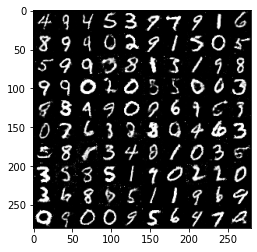

In [21]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

In [14]:
# Saving params.
torch.save(D.state_dict(), 'D.pkl')
torch.save(G.state_dict(), 'G.pkl')